* 예제 핵심 : dcm 데이터의 pixelData부분을 matplotlib을 통해 이미지 출력 
* Jupyter notebook 에서 바로 matplotlib 결과 출력하려면 %matplotlib inline 처리 필요 (python코드로 할 경우 GUI가 뜸)
* matplotlib.pyplot.imgshow의 cmap : 색 조합 테마에 대한 설정 (https://frhyme.github.io/python-lib/matplotlib_extracting_color_from_cmap/) / bone의 경우 검은색~남색~흰색 계통 (참고 : https://matplotlib.org/examples/color/colormaps_reference.html)

In [27]:
%matplotlib inline

View DICOM images using Python image Library (PIL)
Usage:
>>> import pydicom
>>> from pydicom.contrib.pydicom_PIL import show_PIL
>>> ds = pydicom.read_file("filename")
>>> show_PIL(ds)
Requires Numpy:
    http://numpy.scipy.org/
and Python Imaging Library:
    http://www.pythonware.com/products/pil/


Filename.........: /Users/vuno-bmkim/Documents/project/pydicom/.env/lib/python3.7/site-packages/pydicom/data/test_files/CT_small.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.2

Patient's name...: CompressedSamples, CT1
Patient id.......: 1CT1
Modality.........: CT
Study Date.......: 20040119
Image size.......: 128 x 128, 32768 bytes
Pixel spacing....: ['0.661468', '0.661468']
Slice location...: -77.2040634155


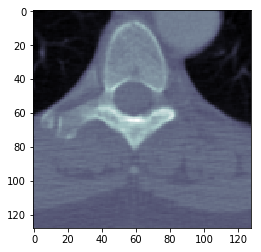

In [36]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

filename = get_testdata_files('CT_small.dcm')[0]
dataset = pydicom.dcmread(filename)


# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name #family_name, given_name, middle_name, name_prefix, name_suffix
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)
if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

* PIL을 써서 multiframe도 출력하는 코드가 있긴 한데 (https://github.com/pydicom/contrib-pydicom/blob/master/viewers/pydicom_PIL.py) 이미지가 너무 깨져서 보이며 mutliframe이 하나로 합쳐지는 건지 어떻게 출력되는것인지 파악 안됨 (아래 코드 참고)

In [31]:
# pydicom_PIL.py

"""View DICOM images using Python image Library (PIL)
Usage:
>>> import pydicom
>>> from pydicom.contrib.pydicom_PIL import show_PIL
>>> ds = pydicom.read_file("filename")
>>> show_PIL(ds)
Requires Numpy:
    http://numpy.scipy.org/
and Python Imaging Library:
    http://www.pythonware.com/products/pil/
"""
# Copyright (c) 2009 Darcy Mason, Adit Panchal
# This file is part of pydicom, relased under an MIT license.
#    See the file LICENSE included with this distribution, also
#    available at https://github.com/pydicom/pydicom

# Based on image.py from pydicom version 0.9.3,
#    LUT code added by Adit Panchal
# Tested on Python 2.5.4 (32-bit) on Mac OS X 10.6
#    using numpy 1.3.0 and PIL 1.1.7b1

have_PIL = True
try:
    import PIL.Image
except ImportError:
    have_PIL = False

have_numpy = True
try:
    import numpy as np
except ImportError:
    have_numpy = False


def get_LUT_value(data, window, level):
    """Apply the RGB Look-Up Table for the given
       data and window/level value."""
    if not have_numpy:
        raise ImportError("Numpy is not available."
                          "See http://numpy.scipy.org/"
                          "to download and install")
    try:
        window = window[0]
    except TypeError:
        pass
    try:
        level = level[0]
    except TypeError:
        pass

    return np.piecewise(data,
                        [data <= (level - 0.5 - (window - 1) / 2),
                         data > (level - 0.5 + (window - 1) / 2)],
                        [0, 255, lambda data: ((data - (level - 0.5)) /
                         (window - 1) + 0.5) * (255 - 0)])


def get_PIL_image(dataset):
    """Get Image object from Python Imaging Library(PIL)"""
    if not have_PIL:
        raise ImportError("Python Imaging Library is not available. "
                          "See http://www.pythonware.com/products/pil/ "
                          "to download and install")

    if ('PixelData' not in dataset):
        raise TypeError("Cannot show image -- DICOM dataset does not have "
                        "pixel data")
    # can only apply LUT if these window info exists
    if ('WindowWidth' not in dataset) or ('WindowCenter' not in dataset):
        bits = dataset.BitsAllocated
        samples = dataset.SamplesPerPixel
        """
        if bits == 8 and samples == 1:
            mode = "L"
        elif bits == 8 and samples == 3:
            mode = "RGB"
        elif bits == 16:
            # not sure about this -- PIL source says is 'experimental'
            # and no documentation. Also, should bytes swap depending
            # on endian of file and system??
            mode = "I;16"
        else:
            raise TypeError("Don't know PIL mode for %d BitsAllocated "
                            "and %d SamplesPerPixel" % (bits, samples))
        """
        mode = "RGB"

        # PIL size = (width, height)
        size = (dataset.Columns, dataset.Rows)

        # Recommended to specify all details
        # by http://www.pythonware.com/library/pil/handbook/image.htm
        im = PIL.Image.frombuffer(mode, size, dataset.PixelData,
                                  "raw", mode, 0, 1)

    else:
        image = get_LUT_value(dataset.pixel_array, dataset.WindowWidth,
                              dataset.WindowCenter)
        # Convert mode to L since LUT has only 256 values:
        #   http://www.pythonware.com/library/pil/handbook/image.htm
        im = PIL.Image.fromarray(image).convert('L')

    return im


def show_PIL(dataset):
    """Display an image using the Python Imaging Library (PIL)"""
    im = get_PIL_image(dataset)
    im.show()
    
filename = "bmode.dcm"
dataset = pydicom.dcmread(filename)
show_PIL(dataset)